# Introduction

Two-sample Mendelian Randomization (MR) is a powerful statistical method used to infer causal relationships between risk factors and health outcomes using genetic data. In this approach, genetic variants associated with an exposure (such as cholesterol levels) are used as instruments to assess their effect on an outcome (like heart disease) in separate, independent samples. By leveraging genetic variants, which are randomly allocated and less influenced by confounding factors, two-sample MR provides a robust way to estimate causal effects and avoid some of the biases present in traditional observational studies.

This method involves obtaining summary statistics from two distinct datasets: one for the exposure and one for the outcome. By combining these datasets, researchers can estimate the causal effect of the exposure on the outcome with increased statistical power and precision. Two-sample MR is widely used in public health and biostatistics to provide insights into how modifiable risk factors impact health outcomes, guiding more effective prevention and treatment strategies.

In this notebook you will perform a two-sample Mendelian Randomization study. We will apply MR-IVW (Inverse-Variance Weighted) and MR-Egger on a toy dataset to estimate causal effects. MR-IVW combines multiple genetic instruments by weighting them according to their precision, assuming all instruments are valid. In contrast, MR-Egger Regression allows for potential pleiotropy (where instruments affect the outcome through pathways other than the exposure) by including an intercept term to adjust for directional pleiotropy, providing a more flexible approach when there are concerns about instrument validity. At the end there is a bonus question to run five main MR methods all together on the simulated data and analyze the results.

# Load and preprocess the data

First please load the data in `../data/MR_genotype_data_with_missing.csv` and `../data/MR_phenotype_data_with_missing.csv` and name them `genotype_data` and `phenotype_data`. Keep the names same before and after the imputation.

***

**Question 1: analyze the pattern of missing data in the phenotype dataset. Are there any specific patterns (e.g., missingness concentrated in certain columns or rows)?**

**Answer:**

In [1]:
library(tidyverse)

Warning message:
"package 'ggplot2' was built under R version 4.3.3"
Warning message:
"package 'dplyr' was built under R version 4.3.2"
Warning message:
"package 'stringr' was built under R version 4.3.2"
── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
genotype_data = read.csv("MR_genotype_data_with_missing.csv")
phenotype_data = read.csv("MR_phenotype_data_with_missing.csv")

In [4]:
any(is.na(phenotype_data[,1]))
any(is.na(phenotype_data[,2]))
any(is.na(phenotype_data[,3]))
any(is.na(phenotype_data[,4]))
phenotype_data_missing = phenotype_data |> 
  filter(is.na(Exposure) | is.na(Outcome))

[1] FALSE

[1] TRUE

[1] TRUE

[1] FALSE

According to the results, we can find that the missing data is primarily concentrated in the outcome and exposure variables, while there is no significant relationship with gender and age. Therefore, gender and age can be considered as having no influence on the likelihood of missingness.

***

**Question 2: given the missingness of data, please perform mode imputation for the genotype data and mean imputation for the phenotype data. Report what is the average age after imputation?**

**Answer:**

In [5]:
get_mode <- function(v) {
  freq_table <- table(v)
  mode_values <-
    as.numeric(names(freq_table[freq_table == max(freq_table)]))
  return(mode_values)
}

In [6]:
# impute the genotype data with mode
for(i in 2:ncol(genotype_data)) {
  X = genotype_data[, i]
  genotype_data[, i] =
    replace(X, is.na(X), get_mode(genotype_data[, i]))
}
any(is.na(genotype_data))

[1] FALSE

In [7]:
# impute the phenotype data with mean
for(i in c(2, 3)) {
  X = phenotype_data[, i]
  phenotype_data[, i] =
    replace(X, is.na(X), mean(phenotype_data[, i], na.rm = TRUE))
}
any(is.na(phenotype_data))
mean(phenotype_data[,4])

[1] FALSE

[1] 49.65433

The average age after imputation is 49.6 years old.

***

# Instrument selection

Now we can use the genotype data to calculate SNP-exposure associations (i.e., estimate the beta values for SNPs). Basically you can do a linear regression between the exposure and each variant and collect the coefficients:

In [ ]:
snp_exposure_results <- data.frame(SNP = colnames(genotype_data)[-1],
                                    Beta = numeric(ncol(genotype_data) - 1),
                                    SE = numeric(ncol(genotype_data) - 1))

for (snp in colnames(genotype_data)[-1]) {
  genotype <- genotype_data[[snp]]
  exposure <- phenotype_data$Exposure
  fit <- lm(exposure ~ genotype)
  snp_exposure_results$Beta[snp_exposure_results$SNP == snp] <- coef(fit)[2]
  snp_exposure_results$SE[snp_exposure_results$SNP == snp] <- summary(fit)$coefficients[2, 2]
}

***

**Question 3: please only select the variants with p-value smaller than 0.01. How many are there?**

**Answer:**

In [9]:
library(broom)

snp_exposure_results <- data.frame(
  SNP = colnames(genotype_data)[-1],
  Beta = numeric(ncol(genotype_data) - 1),
  SE = numeric(ncol(genotype_data) - 1)
)

for (snp in colnames(genotype_data)[-1]) {
  genotype <- genotype_data[[snp]]
  exposure <- phenotype_data$Exposure
  fit <- lm(exposure ~ genotype)
  if (glance(fit)$p.value < 0.05) {
    snp_exposure_results$Beta[snp_exposure_results$SNP == snp] <-
      coef(fit)[2]
    snp_exposure_results$SE[snp_exposure_results$SNP == snp] <-
      summary(fit)$coefficients[2, 2]
  }
}

snp_exposure_results = snp_exposure_results |>
  filter(Beta != 0)

nrow(snp_exposure_results)

[1] 26

There are 26 variants with p-value smaller than 0.01.

***

# SNP-outcome association

***

**Question 4: please run the association analysis between variants and the outcome.**

**Answer:**

In [10]:
snp_outcome_results <- data.frame(
  SNP = colnames(genotype_data)[-1],
  Beta = numeric(ncol(genotype_data) - 1),
  SE = numeric(ncol(genotype_data) - 1)
)

for (snp in colnames(genotype_data)[-1]) {
  genotype <- genotype_data[[snp]]
  outcome <- phenotype_data$Outcome
  fit <- lm(outcome ~ genotype)
  if (glance(fit)$p.value < 0.05) {
    snp_outcome_results$Beta[snp_outcome_results$SNP == snp] <-
      coef(fit)[2]
    snp_outcome_results$SE[snp_outcome_results$SNP == snp] <-
      summary(fit)$coefficients[2, 2]
  }
}

snp_outcome_results = snp_outcome_results |>
  filter(Beta != 0)

nrow(snp_outcome_results)

[1] 23

There are 23 variants with p-value smaller than 0.01.

***

# Run two-sample MR

Now we are ready to run the two-sample MR analysis. Here we can use a R package called [`MendelianRandomization` on CRAN](https://cran.r-project.org/web/packages/MendelianRandomization/index.html).

In [13]:
# Install MendelianRandomization package if not already installed
if (!requireNamespace("MendelianRandomization", quietly = TRUE)) {
  install.packages("MendelianRandomization")
}

# Load the package
library(MendelianRandomization)

Warning message:
"package 'MendelianRandomization' was built under R version 4.3.3"


In the vignette [here](https://cran.r-project.org/web/packages/MendelianRandomization/vignettes/Vignette_MR.pdf), please learn how to apply two basic MR methods -- MR-IVW amd MR-Egger. 

**Hint: the input for `mr_ivw` function consists of four components: coefficients and standard errors between variants and exposures, and between variants and outcome. Same for `mr_egger`. Check page 4 and 6 on the vignette PDF.**

***

**Question 5: please run the MR-IVW and MR-Egger analysis.**

**Answer:**

In [11]:
snp_exposure_results <- data.frame(
  SNP = colnames(genotype_data)[-1],
  Beta = numeric(ncol(genotype_data) - 1),
  SE = numeric(ncol(genotype_data) - 1)
)

for (snp in colnames(genotype_data)[-1]) {
  genotype <- genotype_data[[snp]]
  exposure <- phenotype_data$Exposure
  fit <- lm(exposure ~ genotype)
  snp_exposure_results$Beta[snp_exposure_results$SNP == snp] <-
    coef(fit)[2]
  snp_exposure_results$SE[snp_exposure_results$SNP == snp] <-
    summary(fit)$coefficients[2, 2]
}

snp_outcome_results <- data.frame(
  SNP = colnames(genotype_data)[-1],
  Beta = numeric(ncol(genotype_data) - 1),
  SE = numeric(ncol(genotype_data) - 1)
)

for (snp in colnames(genotype_data)[-1]) {
  genotype <- genotype_data[[snp]]
  outcome <- phenotype_data$Outcome
  fit <- lm(outcome ~ genotype)
  snp_outcome_results$Beta[snp_outcome_results$SNP == snp] <-
    coef(fit)[2]
  snp_outcome_results$SE[snp_outcome_results$SNP == snp] <-
    summary(fit)$coefficients[2, 2]
}

In [14]:
# MR-IVW
IVWObject <- mr_ivw(
  mr_input(
    bx = snp_exposure_results[, 2],
    bxse = snp_exposure_results[, 3],
    by = snp_outcome_results[, 2],
    byse = snp_outcome_results[, 3]
  )
)
IVWObject


Inverse-variance weighted method
(variants uncorrelated, random-effect model)

Number of Variants : 50 

------------------------------------------------------------------
 Method Estimate Std Error 95% CI       p-value
    IVW    1.112     0.153 0.812, 1.413   0.000
------------------------------------------------------------------
Residual standard error =  2.309 
Heterogeneity test statistic (Cochran's Q) = 261.1731 on 49 degrees of freedom, (p-value = 0.0000). I^2 = 81.2%. 
F statistic = 4.9. 

In [15]:
# MR-Egger
EggerObject <- mr_egger(
  mr_input(
    bx = snp_exposure_results[, 2],
    bxse = snp_exposure_results[, 3],
    by = snp_outcome_results[, 2],
    byse = snp_outcome_results[, 3]
  )
)
EggerObject


MR-Egger method
(variants uncorrelated, random-effect model)

Number of Variants =  50 

------------------------------------------------------------------
      Method Estimate Std Error  95% CI       p-value
    MR-Egger    0.754     0.337  0.094, 1.415   0.025
 (intercept)    0.047     0.040 -0.030, 0.125   0.234
------------------------------------------------------------------
Residual Standard Error :  2.299 
Heterogeneity test statistic = 253.6721 on 48 degrees of freedom, (p-value = 0.0000)
I^2_GX statistic: 1.1%

***

# Analyze the results

***

**Question 6: Using the MR-IVW and MR-Egger methods, report the estimated causal effect of the exposure on the outcome, along with standard errors, 95% confidence intervals, and p-values. Compare the estimates from MR-IVW and MR-Egger. What are the key differences between the two methods in your results?**

**Answer:**

Using the MR-IVW (Inverse-Variance Weighted) method, the estimated causal effect of the exposure on the outcome is **1.112**, with a standard error of 0.153. The 95% confidence interval (CI) is (0.812, 1.413), and the p-value is <0.000, indicating a statistically significant effect.

Using the MR-Egger method, the estimated causal effect is **0.754**, with a standard error of 0.337. The 95% CI is (0.094, 1.415), and the p-value is 0.025, also suggesting a significant causal effect, though with a wider confidence interval. Additionally, the intercept estimate is 0.047 with a p-value of **0.234**, indicating no significant directional pleiotropy.

**Comparison of MR-IVW and MR-Egger Results：**

- Effect Size Difference: The MR-IVW estimate (1.112) is higher than the MR-Egger estimate (0.754). This suggests that MR-IVW may be slightly biased due to unaccounted pleiotropy.
  
- Confidence Interval Width: MR-Egger produces a wider 95% CI compared to MR-IVW, reflecting greater uncertainty in the causal estimate.
  
- Pleiotropy Adjustment: The MR-Egger intercept is not significantly different from zero (p = 0.234), implying that directional pleiotropy is not a major concern in this case. This suggests that MR-IVW results remain valid.
  
- Heterogeneity Consideration: The high I² value (81.2%) in IVW suggests heterogeneity among SNPs, indicating potential pleiotropy, which MR-Egger attempts to adjust.

***

**Question 7 (optional): Run all the primary Mendelian Randomization methods using the `mr_allmethods` function from the package (use the code below). Visualize the results with the `mr_plot` function. Based on your findings, provide an analysis of the results and discuss the reasons for any observed patterns or outcomes.**

```R
res = mr_allmethods(mr_input(bx=merged_results$Beta_exposure, bxse=merged_results$SE_exposure, 
                               by=merged_results$Beta_outcome, byse=merged_results$SE_outcome), method = "main")
```


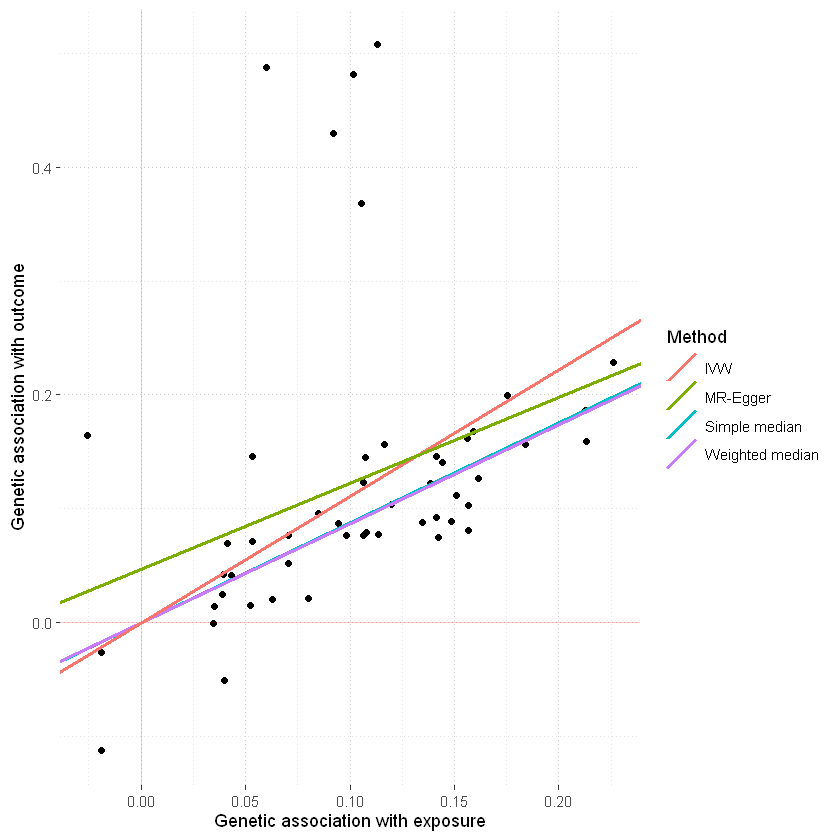

In [16]:
res = mr_allmethods(
  mr_input(
    bx = snp_exposure_results[, 2],
    bxse = snp_exposure_results[, 3],
    by = snp_outcome_results[, 2],
    byse = snp_outcome_results[, 3]
  ),
  method = "main"
)

mr_plot(res)